# Решение задачи:

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras import utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

Установим датасет с изображениями и разархивируем его в папку *watermarked*:

In [ ]:
!wget -q https://storage.yandexcloud.net/academy.ai/watermarked.zip
!unzip -qo "watermarked.zip" -d ./watermarked

Заранее предопределим параметры для дальнейшей работы:

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

Следующая функция создает механизм нанесения водяных знаков: добавляет текст "WM" в случайные позиции на изображение с полупрозрачностью для имитации водяного знака. Использует **OpenCV** для рисования текста:

In [ ]:
#функция создания водяного знака
def add_watermark(img):
    img = img.copy() #копируем изображение, чтобы не модифицировать оригинал
    text = "WM"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    color = (255, 255, 255)
    thickness = 1
    alpha = 0.7

    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0] #получение размеров текста

    overlay = np.zeros_like(img) #создание overlay для полупрозрачного эффекта

    #проверка, чтобы координаты не выходили за границы изображения
    max_x = max(0, img.shape[1] - text_size[0] - 10)
    max_y = max(0, img.shape[0] - text_size[1] - 10)

    if max_x > 0 and max_y > 0:
        for i in range(2):
            x = random.randint(10, max_x) #случайная позиция по X
            y = random.randint(text_size[1] + 10, max_y) #случайная позиция по Y
            cv2.putText(overlay, text, (x, y), font, font_scale, color, thickness, cv2.LINE_AA)

    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img) #смешивание с оригиналом
    return img

Напишем функцию загрузки изображения из директории, ресайзит их до *IMG_SIZE* и возвращает как numpy-массив:

In [ ]:
#загрузка и предобработка данных
def load_images(path, num_images=300):
    images = []
    files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_images]
    for file in files:
        try:
            img = cv2.imread(os.path.join(path, file))
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #ресайз до фиксированного размера
                images.append(img)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images)

Загружаются чистые изображения, затем на них наносятся водяные знаки с помощью функции `add_watermark`. И создадим изображения с водяными знаками:

In [ ]:
clean_images = load_images('./watermarked/wm-nowm/train/no-watermark') #загрузка исходных изображений

watermarked_images = np.array([add_watermark(img) for img in clean_images]) #создание изображений с водяными знаками

Нормализуем данные:

In [ ]:
clean_images = clean_images.astype('float32') / 255.
watermarked_images = watermarked_images.astype('float32') / 255.

Выполним разделение данных с помощью `train_test_split`:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    watermarked_images, clean_images, test_size=0.2, random_state=42
)

Функция создает модель автокодировщика: **энкодер** с сжимающими слоями (Conv2D + MaxPooling), **декодер** с расширяющими слоями (Conv2D + UpSampling):

In [ ]:
#архитектура автокодировщика
def create_autoencoder():
    input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    #encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    #decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return autoencoder

Создается модель, добавляется **early stopping** для предотвращения переобучения, модель обучается:

In [ ]:
autoencoder = create_autoencoder()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0843 - val_loss: 0.0868
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - loss: 0.0868 - val_loss: 0.0860
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 0.0857 - val_loss: 0.0842
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0838 - val_loss: 0.0797
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.0786 - val_loss: 0.0712
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0675 - val_loss: 0.0531
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 0.0509 - val_loss: 0.0399
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - loss: 0.0393 - val_loss: 0.0344
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.0343 - val_loss: 0.0296
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 0.0314 - val_loss: 0.0271
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0285 - val_loss: 0.0256
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.0267 - val_loss: 0.0253
Epoch 13/50
8

Выполним предсказание на тестовых данных и отобразим 10 примеров для каждого из вариантов: *оригинал*, *с водяным знаком*, *предсказанное* и *шум* (разница):

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step


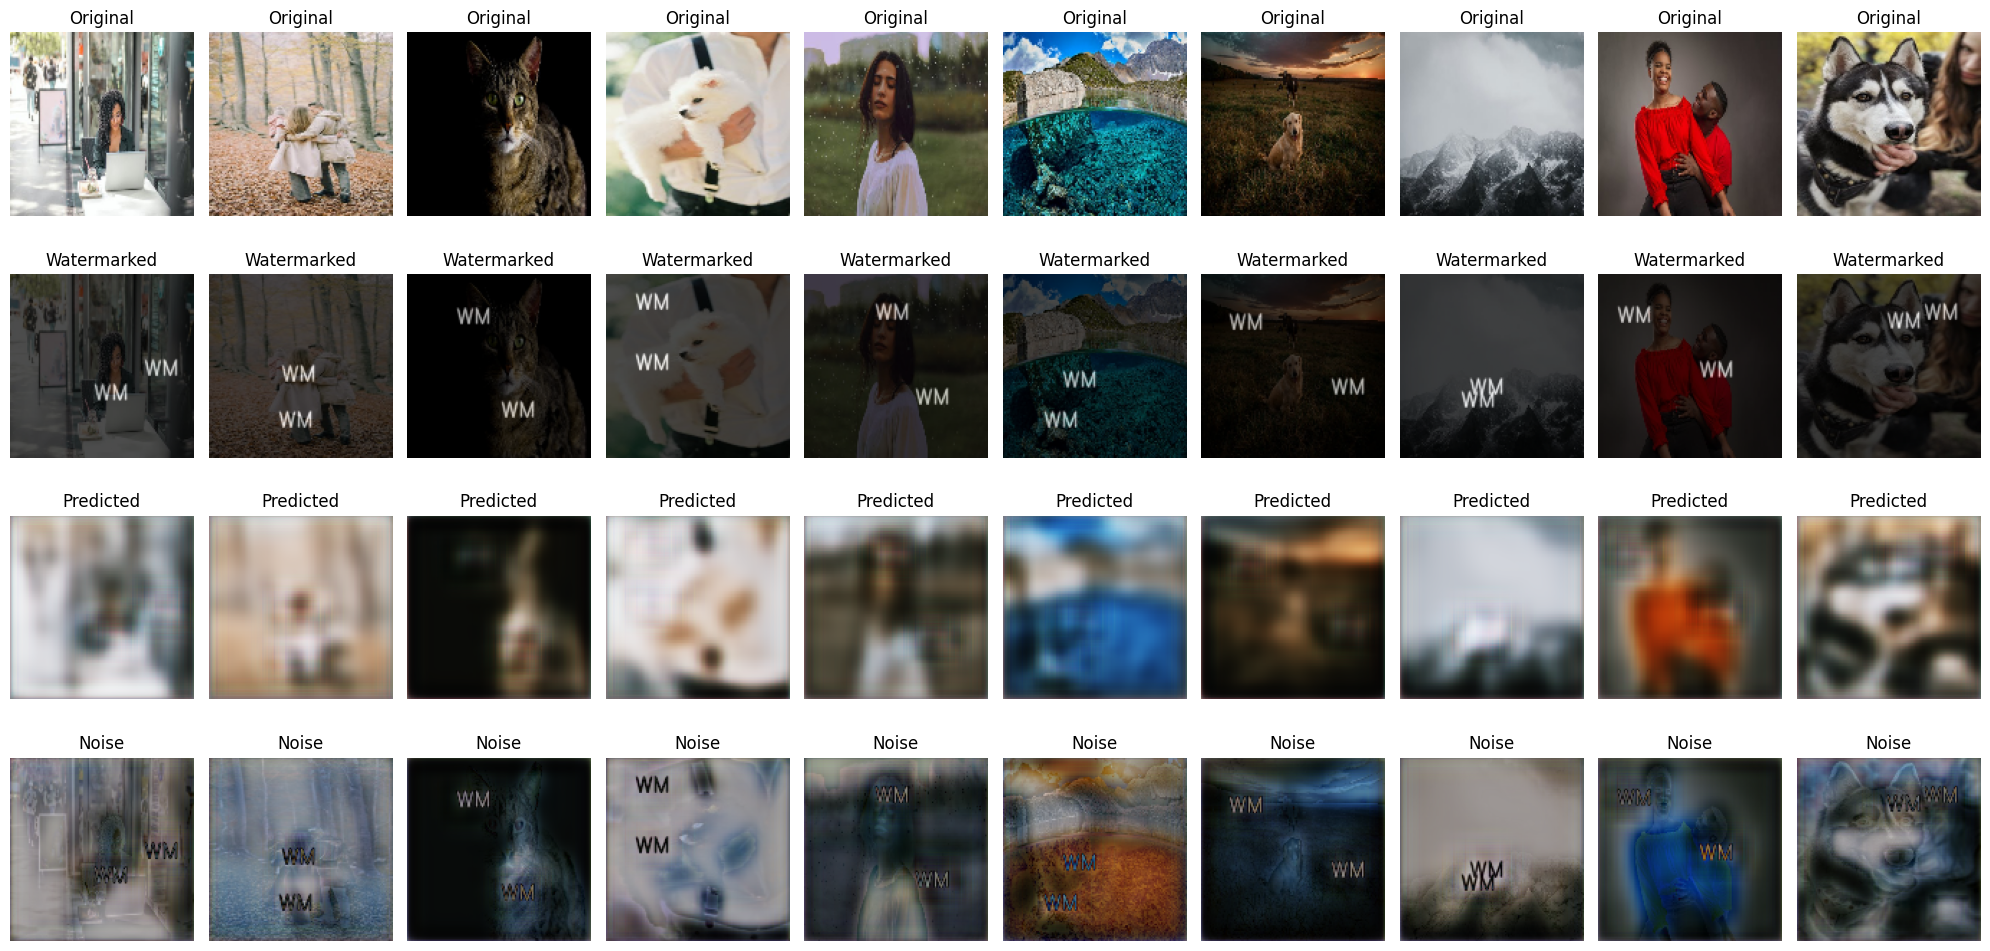

In [ ]:
predictions = autoencoder.predict(X_test) #предсказание на тестовых данных

#визуализация результатов
plt.figure(figsize=(20, 10))
for i in range(10):
    #оригинал
    plt.subplot(4, 10, i + 1)
    plt.imshow(cv2.cvtColor(y_test[i], cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    #с водяным знаком
    plt.subplot(4, 10, i + 11)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.title('Watermarked')
    plt.axis('off')

    #предсказание
    plt.subplot(4, 10, i + 21)
    plt.imshow(cv2.cvtColor(predictions[i], cv2.COLOR_BGR2RGB))
    plt.title('Predicted')
    plt.axis('off')

    #шум
    plt.subplot(4, 10, i + 31)
    noise = np.abs(X_test[i] - predictions[i])
    plt.imshow(noise)
    plt.title('Noise')
    plt.axis('off')

plt.tight_layout()
plt.show()